In [1]:
import math
import queue
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import lightgbm as lgb
from pprint import pprint
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import warnings
FILE_FOLDER = '../prediction_data/%s'
AFTER_FILE_FOLDER = '../prediction_data/afterAnalysis/%s'
MODELS_FOLDER = '../prediction_data/afterAnalysis/models/%s'

/Users/haomao/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [19]:
train_fea = ['temperature', 'humidity', 'pressure','wind_speed', 'year', 'month', 'day', 'hour']
LABELS = ['PM25', 'PM10', 'O3']
date_fear = ['year', 'month', 'day', 'hour']
weather_fea = ['temperature', 'humidity', 'pressure','wind_speed']

LABELS = ['PM25', 'PM10', 'O3']
mean_index = ['temperature','humidity','pressure','wind_speed']
mean_value = [11.22762278,38.31801686,1000.83969531,8.81584084]
std_index = ['temperature','humidity','pressure','wind_speed']
std_value = [11.79542851, 20.34041789, 21.30626417,  6.00146496]


mean = pd.Series(index = mean_index, data = mean_value)
std = pd.Series(index = std_index, data = std_value)

In [21]:
print(mean)
print(std)

temperature      11.227623
humidity         38.318017
pressure       1000.839695
wind_speed        8.815841
dtype: float64
temperature    11.795429
humidity       20.340418
pressure       21.306264
wind_speed      6.001465
dtype: float64


In [7]:
df_sample = pd.read_csv(FILE_FOLDER % 'sample_submission.csv')
orderd_station_name = df_sample['test_id'].str.split('#',expand = True)[0]
orderd_list = orderd_station_name.unique().tolist()

In [9]:
df_test = pd.read_csv(AFTER_FILE_FOLDER % 'test_weather.csv')
test_list = df_test['aq_station_id'].unique().tolist()
orderd_list == test_list

True

In [11]:
df_test['date'] = pd.to_datetime(df_test['time'])
df_test['year'] = df_test['date'].dt.year
df_test['month'] = df_test['date'].dt.month
df_test['day'] = df_test['date'].dt.day
df_test['hour'] = df_test['date'].dt.hour
df_test.head(8)

,aq_station_id,temperature,humidity,pressure,wind_speed,time,date,year,month,day,hour
0,dongsi_aq,19.54,37.17,1009.50,14.98,2018-05-01 00:00:00,2018-05-01 00:00:00,2018,5,1,0
1,dongsi_aq,20.79,32.71,1009.60,17.21,2018-05-01 01:00:00,2018-05-01 01:00:00,2018,5,1,1
2,dongsi_aq,21.00,27.41,1009.83,18.76,2018-05-01 02:00:00,2018-05-01 02:00:00,2018,5,1,2
3,dongsi_aq,20.79,24.41,1010.02,19.99,2018-05-01 03:00:00,2018-05-01 03:00:00,2018,5,1,3
4,dongsi_aq,22.00,20.21,1008.95,19.76,2018-05-01 04:00:00,2018-05-01 04:00:00,2018,5,1,4
5,dongsi_aq,22.25,20.46,1008.56,19.14,2018-05-01 05:00:00,2018-05-01 05:00:00,2018,5,1,5
6,dongsi_aq,22.00,21.46,1008.57,16.97,2018-05-01 06:00:00,2018-05-01 06:00:00,2018,5,1,6
7,dongsi_aq,21.00,22.96,1008.58,12.99,2018-05-01 07:00:00,2018-05-01 07:00:00,2018,5,1,7


# Prediction

In [17]:
def pred_plot(pred,label):
    warmup_steps = 1000
    signal_pred = pred[:warmup_steps]
    plt.figure(figsize=(15,5))

    # Plot and compare the two signals.
    plt.plot(signal_pred, label='pred')
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
    plt.ylabel(label)
    plt.legend()
    plt.show()

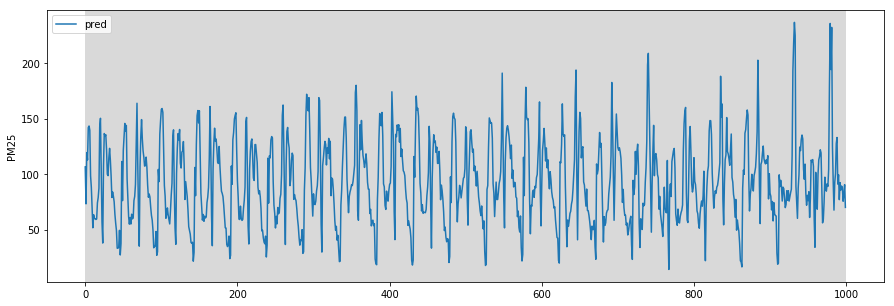

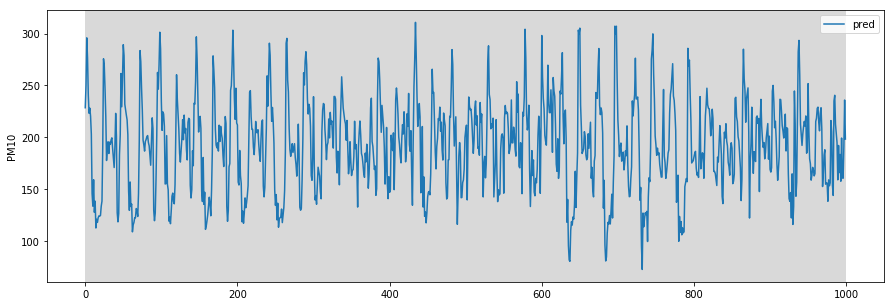

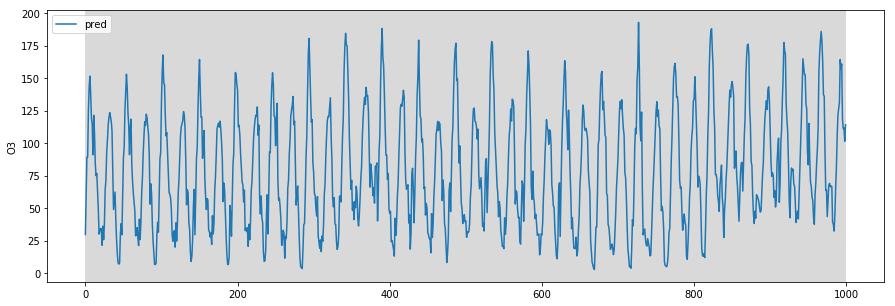

In [23]:
test_X = df_test[train_fea].copy()
pred_dict = {}

test_X[weather_fea] = (test_X[weather_fea] - mean) / std

for label in LABELS:
    gbm = lgb.Booster(model_file = MODELS_FOLDER % ('gmb_model_%s_log.txt'%label))
    pred = gbm.predict(test_X)
    
    pred_nor = np.power(np.e , pred)
    pred_plot(pred_nor,label)
    pred_dict[label] = pred_nor

In [24]:
pred_dict

{'PM25': array([106.41109675,  73.11850025, 119.32708626, ...,  49.64086467,
         27.2454639 ,  28.8521294 ]),
 'PM10': array([228.53869223, 250.11672404, 295.8770126 , ..., 156.05246453,
        193.89185635, 266.13782215]),
 'O3': array([29.8388792 , 57.67979591, 89.24238751, ...,  3.5271938 ,
        19.38767834, 37.02375791])}

In [58]:
df_pred = pd.DataFrame()
df_pred['test_id'] = df_sample['test_id']
for k,v in pred_dict.items():
    df_pred[k] = v

In [60]:
df_sample.columns

Index(['test_id', 'PM2.5', 'PM10', 'O3'], dtype='object')

In [61]:
df_pred.columns = df_sample.columns

In [64]:
df_pred.to_csv('submission.csv',index = False)